# Game Tweets

1. Load necessary libraries 
2. Load data into Jupyter Notebook 
3. Clean text  
    a. Remove emoji's   
    b. Remove weblinks  
    c. Remove hashtags  
    d. Remove usernames  
    e. Remove extra whitespace  
    f. Remove "RT"  
    g. Remove anything following "/" 
4. Add cleaned text (Step 3) to full dataframe 
5. Remove duplicate tweets using the cleaned text 
6. Create new dataframe that contains "game-like" tweets 
7. Create new dataframe that separates tweets by team (KS, TB) 
8. Sentiment analysis of  
    a. Cleaned full tweets  
    b. Cleaned game tweets  
    c. Cleaned team tweets
9. Data visualization for sentiment analysis      
    a. Distribution of polarity  
10. Use NLP and SpaCy to clean text   
    a. Full tweets  
    b. Game tweets  
    c. Team tweets
11. Word Clouds and counts for most positive and most negative polarity scores
12. DBSCAN Clustering  
    a. Perform on the two sets of data (full, game)  
    b. Determine Epsilon and Minimum number of Points in each cluster  
    c. Compute silhouette score to determine "optimal" eps and minPts  
    d. Plot clusters  
    e. Identify contents of each cluster  
    f. Performance metrics  


## 1. Load Libraries and MongoDB Data

In [1]:
#libraries

import pandas as pd #to create dataframe
from pymongo import MongoClient #load data from MongoDB
from pprint import pprint #print data from MongoDB
import re
import spacy
import nltk
import string #to remove punct and digits
import time #count the number of seconds that have passed
from collections import defaultdict #create dict to hold more than 1 value per key
import textblob #sentiment analysis
     
import matplotlib.pyplot as plt #generate a word cloud image and bar plots
from wordcloud import WordCloud
import seaborn as sns
from nltk import FreqDist #count top frequent words
import numpy as np
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer #create TD-IDF features
from sklearn import metrics #performance metrics

## 2. Load Game Tweets from MongoDB

In [2]:
#check that data was written to MongoDB
client = MongoClient()
db = client['Superbowl_2021']
tweets = db['Superbowl_post_game_tweets']

pprint(tweets.find_one())

client.close()

{'Date': 'Mon Jan 25 15:45:06 +0000 2021',
 'Hashtags': [],
 'Location': 'Denver, CO',
 'Retweeted': False,
 'Time Zone': None,
 'Tweet': 'Patrick Mahomes /  Another legendary performance from Patrick '
          'Mahomes on Sunday sets up what I call a “Delayed… '
          'https://t.co/QgUt0d0Ltf',
 'User': 'FantasySP',
 '_id': ObjectId('600ee787f282116a645ed444')}


In [3]:
tweets_df = pd.DataFrame(list(tweets.find())) #[1] convert mongoDB data to pandas dataframe
tweets_df.head()

,_id,Date,User,Tweet,Retweeted,Hashtags,Time Zone,Location
0,600ee787f282116a645ed444,Mon Jan 25 15:45:06 +0000 2021,FantasySP,Patrick Mahomes / Another legendary performan...,False,[],None,"Denver, CO"
1,600ee787f282116a645ed445,Mon Jan 25 15:45:06 +0000 2021,schlidin,@Splashxgod @SpearsKhayre Chiefs offense isn’t...,False,[],None,"Orlando, FL"
2,600ee787f282116a645ed446,Mon Jan 25 15:45:06 +0000 2021,KamWitIt,"@espn “me, my bucs and my refs will see you in...",False,[],None,"Baton Rouge, LA"
3,600ee787f282116a645ed447,Mon Jan 25 15:45:06 +0000 2021,jeffbrack,@Martin72m1 @geoffschwartz I don't blame anyon...,False,[],None,"Prairie Village, KS"
4,600ee787f282116a645ed448,Mon Jan 25 15:45:06 +0000 2021,DannySt_Fortune,If you swap the top and lower halves of Brie L...,False,[],None,"Silverlake, CA"


In [4]:
tweets_df.shape #dimensions of tweets_df

(81704, 8)

In [5]:
tweets_df.columns #column names

Index(['_id', 'Date', 'User', 'Tweet', 'Retweeted', 'Hashtags', 'Time Zone',
       'Location'],
      dtype='object')

In [6]:
tweets_df["Tweet"].iloc[0:10] #look at first 10 "Tweet"

0    Patrick Mahomes /  Another legendary performan...
1    @Splashxgod @SpearsKhayre Chiefs offense isn’t...
2    @espn “me, my bucs and my refs will see you in...
3    @Martin72m1 @geoffschwartz I don't blame anyon...
4    If you swap the top and lower halves of Brie L...
5    @Realrclark25 @mspears96 I just can't understa...
6    RT @NFL_Memes: Bill Belichick watching everyon...
7    RT @MrAhmednurAli: Funny how people can separa...
8    @Semperfiguy8 @TheRealJRB55 @ThePoniExpress Fa...
9    IF ARRON ROGER WINS = HAVE TO STAY IN GREEN-BA...
Name: Tweet, dtype: object

## 3. Clean Text Using `RegEx`

*This includes removing emojis, weblinks, usernames, extra whitespace, and any other unnecessary characters*

In [7]:
count = 0 
for tweet in tweets_df["Tweet"]:
    if count <=20: # view first 20 tweets (before cleaning)
        print(count, tweet)
        count = count + 1

0 Patrick Mahomes /  Another legendary performance from Patrick Mahomes on Sunday sets up what I call a “Delayed… https://t.co/QgUt0d0Ltf
1 @Splashxgod @SpearsKhayre Chiefs offense isn’t so high powered Its MAX, remember the ravens last year before the pl… https://t.co/bqznht1frN
2 @espn “me, my bucs and my refs will see you in tampa on February 7th” https://t.co/Q83xg8Phgq
3 @Martin72m1 @geoffschwartz I don't blame anyone who chose to opt out, but it would've been real nice to see what ki… https://t.co/T0HqKtgos6
4 If you swap the top and lower halves of Brie Larson and Rami Malek’s face, you get Tom Brady and Jodie Foster.
5 @Realrclark25 @mspears96 I just can't understand how what Todd Bowles did has just been ignore. What other game doe… https://t.co/rptuH6iMOC
6 RT @NFL_Memes: Bill Belichick watching everyone realize Tom Brady was the system... https://t.co/2KXGuVhI4e
7 RT @MrAhmednurAli: Funny how people can separate Tom Brady’s politics from his game, but struggle to do the same

In [8]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string) 

In [9]:
tweets_df["Tweet"][5]

"@Realrclark25 @mspears96 I just can't understand how what Todd Bowles did has just been ignore. What other game doe… https://t.co/rptuH6iMOC"

In [10]:
remove_emoji(tweets_df["Tweet"][5]) #apply function above to fifth tweet

"@Realrclark25 @mspears96 I just can't understand how what Todd Bowles did has just been ignore. What other game doe… https://t.co/rptuH6iMOC"

In [11]:
no_emoji = tweets_df["Tweet"].apply(remove_emoji) #apply function above to all tweets

In [12]:
#search for weblinks in `no_emoji` tweets

counter = 0
count = 0
for x in no_emoji:
    if re.search('http://\S+', x) and counter <=5: 
        counter = counter + 1
        print(counter, x)
    if re.search('https://\S+', x) and count <=5:
        count = count + 1
        print(count, x)

1 Patrick Mahomes /  Another legendary performance from Patrick Mahomes on Sunday sets up what I call a “Delayed… https://t.co/QgUt0d0Ltf
2 @Splashxgod @SpearsKhayre Chiefs offense isn’t so high powered Its MAX, remember the ravens last year before the pl… https://t.co/bqznht1frN
3 @espn “me, my bucs and my refs will see you in tampa on February 7th” https://t.co/Q83xg8Phgq
4 @Martin72m1 @geoffschwartz I don't blame anyone who chose to opt out, but it would've been real nice to see what ki… https://t.co/T0HqKtgos6
5 @Realrclark25 @mspears96 I just can't understand how what Todd Bowles did has just been ignore. What other game doe… https://t.co/rptuH6iMOC
6 RT @NFL_Memes: Bill Belichick watching everyone realize Tom Brady was the system... https://t.co/2KXGuVhI4e
1 RT @ProFootballTalk: Tom Brady could be sliding out of the league's elite quarterbacks http://is.gd/5l7aY #NFL
2 RT @ProFootballTalk: Tom Brady could be sliding out of the league's elite quarterbacks http://is.gd/5l7aY #NFL
3

In [13]:
#remove http://, \S is anything that is not a space
no_html_tweets = no_emoji.apply(lambda x: re.sub('http://\S+', '', x))

In [14]:
#remove https://
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('https://\S+', '', x))

In [15]:
#remove @usernames
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('@\S+', '', x))

In [16]:
#remove #hashtags
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('#\S+', '', x))

In [17]:
#Remove RT
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('RT', '', x))

In [18]:
#remove /
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('/\S+', '', x))

In [19]:
#remove extra whitespace
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('\s\s+', ' ', x))

In [20]:
no_html_tweets.iloc[0:10] #print first 10 cleaned tweets

0    Patrick Mahomes / Another legendary performanc...
1     Chiefs offense isn’t so high powered Its MAX,...
2     “me, my bucs and my refs will see you in tamp...
3     I don't blame anyone who chose to opt out, bu...
4    If you swap the top and lower halves of Brie L...
5     I just can't understand how what Todd Bowles ...
6     Bill Belichick watching everyone realize Tom ...
7     Funny how people can separate Tom Brady’s pol...
8     Facts lmao I’d rather the chiefs take this. A...
9    IF ARRON ROGER WINS = HAVE TO STAY IN GREEN-BA...
Name: Tweet, dtype: object

In [21]:
#print cleaned and original tweets
print("Original Tweets: \n")
count = 0 
for tweet in tweets_df["Tweet"]:
    if count <=20: # view first 20 tweets (before cleaning)
        print(count, tweet)
        count = count + 1
print("\n")
print("Cleaned Tweets: \n")
count = 0
for tweet in no_html_tweets:
    if count <=20: # view first 20 tweets (after cleaning)
        print(count, tweet)
        count = count + 1

Original Tweets: 

0 Patrick Mahomes /  Another legendary performance from Patrick Mahomes on Sunday sets up what I call a “Delayed… https://t.co/QgUt0d0Ltf
1 @Splashxgod @SpearsKhayre Chiefs offense isn’t so high powered Its MAX, remember the ravens last year before the pl… https://t.co/bqznht1frN
2 @espn “me, my bucs and my refs will see you in tampa on February 7th” https://t.co/Q83xg8Phgq
3 @Martin72m1 @geoffschwartz I don't blame anyone who chose to opt out, but it would've been real nice to see what ki… https://t.co/T0HqKtgos6
4 If you swap the top and lower halves of Brie Larson and Rami Malek’s face, you get Tom Brady and Jodie Foster.
5 @Realrclark25 @mspears96 I just can't understand how what Todd Bowles did has just been ignore. What other game doe… https://t.co/rptuH6iMOC
6 RT @NFL_Memes: Bill Belichick watching everyone realize Tom Brady was the system... https://t.co/2KXGuVhI4e
7 RT @MrAhmednurAli: Funny how people can separate Tom Brady’s politics from his game, but stru

## 4. Add Cleaned Tweets to Dataframe

In [22]:
type(no_html_tweets)

pandas.core.series.Series

In [23]:
tweets_df["Clean Tweets"] = no_html_tweets
tweets_df.columns

Index(['_id', 'Date', 'User', 'Tweet', 'Retweeted', 'Hashtags', 'Time Zone',
       'Location', 'Clean Tweets'],
      dtype='object')

In [24]:
tweets_df.head()

,_id,Date,User,Tweet,Retweeted,Hashtags,Time Zone,Location,Clean Tweets
0,600ee787f282116a645ed444,Mon Jan 25 15:45:06 +0000 2021,FantasySP,Patrick Mahomes / Another legendary performan...,False,[],None,"Denver, CO",Patrick Mahomes / Another legendary performanc...
1,600ee787f282116a645ed445,Mon Jan 25 15:45:06 +0000 2021,schlidin,@Splashxgod @SpearsKhayre Chiefs offense isn’t...,False,[],None,"Orlando, FL","Chiefs offense isn’t so high powered Its MAX,..."
2,600ee787f282116a645ed446,Mon Jan 25 15:45:06 +0000 2021,KamWitIt,"@espn “me, my bucs and my refs will see you in...",False,[],None,"Baton Rouge, LA","“me, my bucs and my refs will see you in tamp..."
3,600ee787f282116a645ed447,Mon Jan 25 15:45:06 +0000 2021,jeffbrack,@Martin72m1 @geoffschwartz I don't blame anyon...,False,[],None,"Prairie Village, KS","I don't blame anyone who chose to opt out, bu..."
4,600ee787f282116a645ed448,Mon Jan 25 15:45:06 +0000 2021,DannySt_Fortune,If you swap the top and lower halves of Brie L...,False,[],None,"Silverlake, CA",If you swap the top and lower halves of Brie L...


## 5. Remove Duplicate Tweets

In [25]:
clean_tweets_df = tweets_df.drop_duplicates(subset=['Clean Tweets'])
clean_tweets_df.shape, tweets_df.shape

((30171, 9), (81704, 9))

In [26]:
clean_tweets_df = clean_tweets_df.reset_index(drop=True) 

## 6. Filter "Game-Like" Tweets

In [27]:
values = ["redzone", "ball", "incompletion", "interception", "throw", 
        "catch", "downfield", "oline", "offensive", "defensive", 
       "offense", "defense", "blocking", "block", "win", "lose", "sack", "superbowl",
       "score", "home", "away", "goat", "1st", "2nd", "3rd", "4th", "down", "td", "int", "touchdown", 
        "root", "stop", "pass", "rush", "play", "Tom Brady", "Patrick Mahomes", "Bucs", "Buccaneers", 
          "Gronk", "Gronkowski", "Brady", "TB", "Antonio Brown", "Chiefs", "Kansas City",
          "Travis Kelce", "Kelce", "Mahomes", "KC", "tackle", "offsides", "end zone", "block", "fair", "catch", 
          "field goal", "fumble", "grounding", "neutral", "pocket", "safety", "turnover", "zone", "snap"]

tweet_dict = defaultdict(list)  #dict = key:[val, val,..]

for key in clean_tweets_df["Clean Tweets"]:
    for val in values:
        match = re.search(val, key)
        if match:
            tweet_dict[key].append(val)

In [28]:
len(tweet_dict)

17600

In [29]:
game_tweets = pd.DataFrame(list(tweet_dict.items()), columns=["Tweet", "Keywords"]) 
game_tweets.head()

,Tweet,Keywords
0,Patrick Mahomes / Another legendary performanc...,"[home, Patrick Mahomes, Mahomes]"
1,"Chiefs offense isn’t so high powered Its MAX,...","[offense, Chiefs]"
2,If you swap the top and lower halves of Brie L...,"[Tom Brady, Brady]"
3,Bill Belichick watching everyone realize Tom ...,"[Tom Brady, Brady]"
4,Funny how people can separate Tom Brady’s pol...,"[Tom Brady, Brady]"


## 7. Separate Tweets by Team

In [30]:
# Kansas City Chiefs Tweets

chiefs_keys = ["Patrick Mahomes", "Chiefs", "Kansas City", "Travis Kelce", "Kelce", "Mahomes", "KC", 
"Tyrann Mathieu", "Tyrann", "Mathieu", "Tyreek Hill"]
chiefs = []

for tweet in clean_tweets_df["Clean Tweets"]:
    for key in chiefs_keys:
        if key in tweet and tweet not in chiefs:
            chiefs.append(tweet)
len(chiefs)

5136

In [31]:
# Tampa Bay Buccaneers Tweets

bucs_keys = ["Tom Brady", "Bucs", "Buccaneers", "Gronk", "Gronkowski", "Brady", "TB", "Antonio Brown",
             "Godwin"]
bucs = []

for tweet in clean_tweets_df["Clean Tweets"]:
    for key in bucs_keys:
        if key in tweet and tweet not in bucs:
            bucs.append(tweet)
len(bucs)

9422

## 8. Sentiment Analysis Using `Textblob`

### A. Sentiment Analysis of Full Dataset

In [32]:
tb_0 = textblob.TextBlob(clean_tweets_df["Clean Tweets"][0]) #apply textblob to first tweet

In [33]:
tb_0.sentiment #look at sentiment of first tweet

Sentiment(polarity=1.0, subjectivity=1.0)

In [34]:
tb_0.correct(), tb_0.correct().sentiment #correct spelling of first tweet

(TextBlob("Patrick Homes / Another legendary performance from Patrick Homes on Sunday sets up what I call a “Delayed… "),
 Sentiment(polarity=1.0, subjectivity=1.0))

In [35]:
tb_0.sentiment_assessments #view sentiment assessments of  first tweet

Sentiment(polarity=1.0, subjectivity=1.0, assessments=[(['legendary'], 1.0, 1.0, None)])

In [36]:
full_tb_sentiment_assessments = {} #add sentiment assessments of all tweets to dict

start = time.time()
for r in range(0, len(clean_tweets_df["Clean Tweets"])):
    full_tb_sentiment_assessments[clean_tweets_df["Clean Tweets"][r]] = textblob.TextBlob(clean_tweets_df["Clean Tweets"][r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')



Process took 10 seconds


Can use function below to collect sentiment assessments

In [37]:
# def textblob_sentiments(text, sentiment_dict, keys_list, polarity_list, subj_list, assess_list):
    
# # text is the tweets to be analyzed
# # sentiment_dict is an empty dict 
# # keys_list, polarity_list, subj_list, assess_list are empty lists

#     print("Adding sentiments tuple to dictionary...")
    
#     start = time.time()
#     for r in range(0, len(text)):
#         sentiment_dict[text[r]] = textblob.TextBlob(text[r]).sentiment_assessments 
#         #calculate sentiment assessments and add them to empty dictionary (tweet:sentiment assessments tuple)
    
#     end = time.time()
#     print('Process took', int(round(end - start)), 'seconds') #count number of seconds that it takes to process code above 
    
#     print("Creating new dataframe...")
    
#     for key, value in sentiment_dict.items():
#         keys_list.append(key) #get tweets
#         value_list = list(value) #get sentiment assessments in a list
#         polarity_list.append(value_list[0]) #get polarity scores
#         subj_list.append(value_list[1]) #get subjectivity scores
#         assess_list.append(value_list[2]) #get assessments 
        
#     print("Last step...")
    
#     new_df = pd.DataFrame(zip(text, polarity_list, subj_list, assess_list), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments']) #create new dataframe using lists above
#     return(new_df)

In [38]:
# test_dict = {} #dictionary to calculate and contain sentment assessments
# keys = [] #get keys (tweets) from test_dict
# polarity = [] #get polarity scores
# subjectivity = [] #get subjectivity scores
# assessments = [] #get assessments

# assessments_df = textblob_sentiments(clean_tweets_df["Clean Tweets"], test_dict, keys, polarity, subjectivity, assessments) #apply function above

# assessments_df.head() #check to make sure data was collected correctly

In [39]:
print('There are {} tweets that TextBlob was unable to process.'.format(len(clean_tweets_df["Clean Tweets"])-len(full_tb_sentiment_assessments)))
#view number of tweets that TextBlob was unable to process

There are 0 tweets that TextBlob was unable to process.


In [40]:
list(full_tb_sentiment_assessments.keys())[0], list(full_tb_sentiment_assessments.values())[0]
#view first key (tweet) and first value (sentiment assessments) in dict

('Patrick Mahomes / Another legendary performance from Patrick Mahomes on Sunday sets up what I call a “Delayed… ',
 Sentiment(polarity=1.0, subjectivity=1.0, assessments=[(['legendary'], 1.0, 1.0, None)]))

In [41]:
x = list(full_tb_sentiment_assessments.values())[0] #list format for first value
x

Sentiment(polarity=1.0, subjectivity=1.0, assessments=[(['legendary'], 1.0, 1.0, None)])

In [42]:
x[0], x[1], x[2] #polarity,subjectivity, assessments 

(1.0, 1.0, [(['legendary'], 1.0, 1.0, None)])

In [43]:
#separate keys and values into their own lists

keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in full_tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])


In [44]:
keys[0], polarity[0], subjectivity[0], assessments[0] #ensure keys and values are ordered properly

('Patrick Mahomes / Another legendary performance from Patrick Mahomes on Sunday sets up what I call a “Delayed… ',
 1.0,
 1.0,
 [(['legendary'], 1.0, 1.0, None)])

In [45]:
full_assessments_df = pd.DataFrame(zip(clean_tweets_df["Clean Tweets"], polarity, subjectivity, assessments), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments'])
full_assessments_df.head(5) #create new dataframe for tweets and their assements

,Tweet,Polarity,Subjectivity,Assessments
0,Patrick Mahomes / Another legendary performanc...,1.00,1.000000,"[([legendary], 1.0, 1.0, None)]"
1,"Chiefs offense isn’t so high powered Its MAX,...",0.08,0.303333,"[([high], 0.16, 0.5399999999999999, None), ([l..."
2,"“me, my bucs and my refs will see you in tamp...",0.00,0.000000,[]
3,"I don't blame anyone who chose to opt out, bu...",0.90,1.000000,"[([real, nice], 0.8999999999999999, 1.0, None)]"
4,If you swap the top and lower halves of Brie L...,0.50,0.500000,"[([top], 0.5, 0.5, None)]"


In [46]:
full_assessments_df["Polarity"].mean()

0.11217100947291117

In [47]:
full_assessments_df["Polarity"].round(0).value_counts()

 0.0    26364
 1.0     3004
-1.0      803
Name: Polarity, dtype: int64

### B. Sentiment Analysis of Game-Like Data

In [48]:
tb_sentiment_assessments = {}

start = time.time()
for r in range(0, len(game_tweets["Tweet"])):
    tb_sentiment_assessments[game_tweets["Tweet"][r]]= textblob.TextBlob(game_tweets["Tweet"][r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')


Process took 6 seconds


In [49]:
print('There are {} tweets that TextBlob was unable to process.'.format(len(game_tweets["Tweet"])-len(tb_sentiment_assessments)))

There are 0 tweets that TextBlob was unable to process.


In [50]:
keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])


In [51]:
keys[0], polarity[0], subjectivity[0], assessments[0]

('Patrick Mahomes / Another legendary performance from Patrick Mahomes on Sunday sets up what I call a “Delayed… ',
 1.0,
 1.0,
 [(['legendary'], 1.0, 1.0, None)])

In [52]:
assessments_df = pd.DataFrame(zip(game_tweets["Tweet"], game_tweets["Keywords"], polarity, subjectivity, assessments), columns=['Tweet', 'Keywords', 'Polarity', 'Subjectivity','Assessments'])
assessments_df.head(5)

,Tweet,Keywords,Polarity,Subjectivity,Assessments
0,Patrick Mahomes / Another legendary performanc...,"[home, Patrick Mahomes, Mahomes]",1.00,1.000000,"[([legendary], 1.0, 1.0, None)]"
1,"Chiefs offense isn’t so high powered Its MAX,...","[offense, Chiefs]",0.08,0.303333,"[([high], 0.16, 0.5399999999999999, None), ([l..."
2,If you swap the top and lower halves of Brie L...,"[Tom Brady, Brady]",0.50,0.500000,"[([top], 0.5, 0.5, None)]"
3,Bill Belichick watching everyone realize Tom ...,"[Tom Brady, Brady]",0.00,0.000000,[]
4,Funny how people can separate Tom Brady’s pol...,"[Tom Brady, Brady]",-0.05,0.508333,"[([funny], 0.25, 1.0, None), ([game], -0.4, 0...."


In [53]:
assessments_df["Polarity"].mean()

0.12861129715303818

In [54]:
assessments_df["Polarity"].round(0).value_counts()

 0.0    15270
 1.0     1890
-1.0      440
Name: Polarity, dtype: int64

### C. Sentiment Analysis of Team Data

#### Kansas City Chiefs

In [55]:
chiefs_tb_sentiment_assessments = {}

start = time.time()
for r in range(0, len(chiefs)):
    chiefs_tb_sentiment_assessments[chiefs[r]]= textblob.TextBlob(chiefs[r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')


Process took 2 seconds


In [56]:
keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in chiefs_tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])

chiefs_assessments_df = pd.DataFrame(zip(chiefs,  polarity, subjectivity, assessments), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments'])
chiefs_assessments_df.head(5)

,Tweet,Polarity,Subjectivity,Assessments
0,Patrick Mahomes / Another legendary performanc...,1.000000,1.000000,"[([legendary], 1.0, 1.0, None)]"
1,"Chiefs offense isn’t so high powered Its MAX,...",0.080000,0.303333,"[([high], 0.16, 0.5399999999999999, None), ([l..."
2,If Patrick Mahomes was the QB of the Packers ...,0.066667,0.483333,"[([green], -0.2, 0.3, None), ([super], 0.33333..."
3,Stefon Diggs stayed on the field to watch the...,0.166667,0.583333,"[([super], 0.3333333333333333, 0.6666666666666..."
4,Patrick Mahomes has now been to as many Super...,0.416667,0.583333,"[([many], 0.5, 0.5, None), ([super], 0.3333333..."


In [57]:
chiefs_assessments_df['Polarity'].mean()

0.12157267651967592

In [58]:
chiefs_assessments_df['Polarity'].round(0).value_counts()

 0.0    4531
 1.0     498
-1.0     107
Name: Polarity, dtype: int64

#### Tampa Bay Buccaneers

In [59]:
bucs_tb_sentiment_assessments = {}

start = time.time()
for r in range(0, len(bucs)):
    bucs_tb_sentiment_assessments[bucs[r]]= textblob.TextBlob(bucs[r]).sentiment_assessments
    
end = time.time()
print('Process took', int(round(end - start)), 'seconds')


Process took 3 seconds


In [60]:
keys = []
polarity = []
subjectivity = []
assessments = []

for key, value in bucs_tb_sentiment_assessments.items():
    keys.append(key)
    value_list = list(value)
    polarity.append(value_list[0])
    subjectivity.append(value_list[1])
    assessments.append(value_list[2])

bucs_assessments_df = pd.DataFrame(zip(bucs,  polarity, subjectivity, assessments), columns=['Tweet', 'Polarity', 'Subjectivity','Assessments'])
bucs_assessments_df.head(5)

,Tweet,Polarity,Subjectivity,Assessments
0,If you swap the top and lower halves of Brie L...,0.50,0.500000,"[([top], 0.5, 0.5, None)]"
1,Bill Belichick watching everyone realize Tom ...,0.00,0.000000,[]
2,Funny how people can separate Tom Brady’s pol...,-0.05,0.508333,"[([funny], 0.25, 1.0, None), ([game], -0.4, 0...."
3,The only goddamn thing you need to know about...,0.00,1.000000,"[([only], 0.0, 1.0, None)]"
4,Years in the NFC: Aaron Rodgers - 16\nDrew Br...,0.00,0.000000,[]


In [61]:
bucs_assessments_df['Polarity'].mean()

0.13237289288805792

In [62]:
bucs_assessments_df['Polarity'].round(0).value_counts()

 0.0    8208
 1.0     951
-1.0     263
Name: Polarity, dtype: int64

## 9. Polarity Distributions of Sentiment Scores

In [63]:
#full_assessments_df['Polarity'].round(1).value_counts()

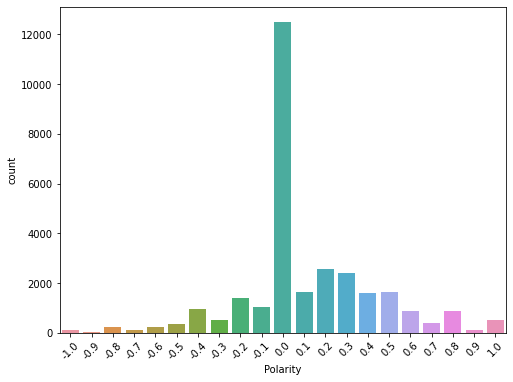

In [64]:
full_polarity = full_assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = full_polarity, data = full_assessments_df) #polarity distribution of full dataset (8.A) sentiments

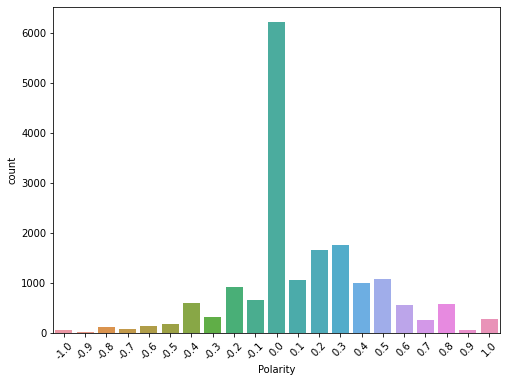

In [65]:
game_polarity = assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = game_polarity, data = assessments_df)  #polarity distribution of game-like data (8.B) sentiments

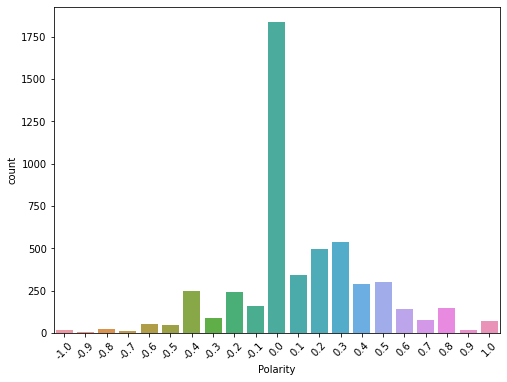

In [66]:
chiefs_polarity = chiefs_assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = chiefs_polarity, data = chiefs_assessments_df) #polarity distribution of Kansas City (8.C) sentiments

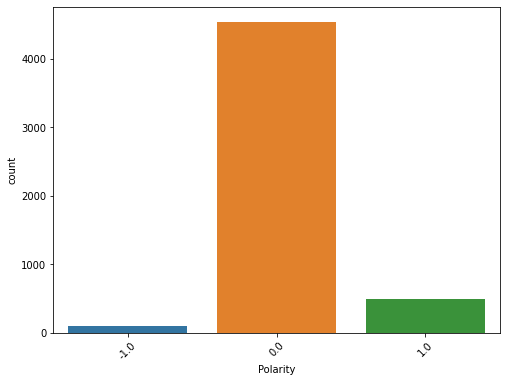

In [67]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = chiefs_assessments_df['Polarity'].round(0), data = chiefs_assessments_df) #polarity distribution of Kansas City (8.C) sentiments

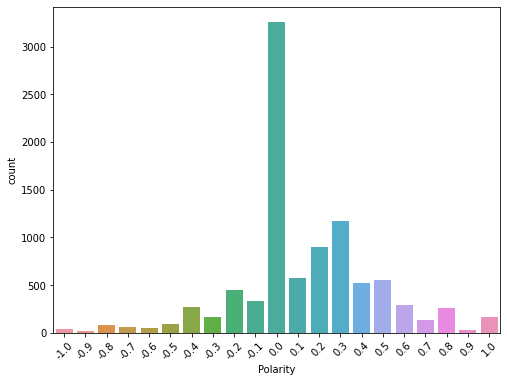

In [68]:
bucs_polarity = bucs_assessments_df['Polarity'].round(1)

plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = bucs_polarity, data = bucs_assessments_df) #polarity distribution of Tampa Bay (8.C) sentiments

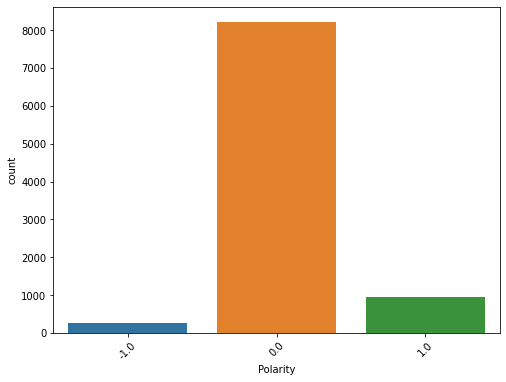

In [69]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=45) 

sns.countplot(x = bucs_assessments_df['Polarity'].round(0), data = bucs_assessments_df) #polarity distribution of Tampa Bay (8.C) sentiments

## 10. Natural Language Processing Using `spaCy`

In [70]:
nlp = spacy.load('en_core_web_lg') #load English spaCy pipeline, large

In [71]:
stopwords = nltk.corpus.stopwords.words('english') #load nltk's English stopword list
stopwords[0:10] #view 10 stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [72]:
stopwords = set(stopwords + ['RT', 'DM', 'retweet',
                             'direct message', 'reply', 'following', 'followers', 
                             'mention', 'hashtag']) 
#adds to list of stopwords above and keep as set()

In [73]:
# simple clean text function -- spacy lowercases, removes stopwords, lemmatizes
    #function from Text Analytics Week 5 Assignment
    
def clean_text(docs):
    # remove punctuation and numbers
    # I do this before lemmatizing, so things like "act's" turn into 'act' instead of 'act s'
    print('removing punctuation and digits')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [d.translate(table) for d in docs]
    
    print('spacy nlp...longest part')
    nlp_docs = [nlp(d) for d in clean_docs]
    
    # keep the word if it's a pronoun, otherwise use the lemma
    # otherwise spacy substitutes '-PRON-' for pronouns
    print('getting lemmas')
    lemmatized_docs = [[w.lemma_ if w.lemma_ != '-PRON-'
                           else w.lower_
                           for w in d]
                      for d in nlp_docs]
    
    # remove stopwords
    print('removing stopwords')
    lemmatized_docs = [[lemma for lemma in doc if lemma not in stopwords] for doc in lemmatized_docs] 

        #remove specific stop words
    
    # join tokens back into doc (string) because lemmatized_docs is a list
    clean_docs = [' '.join(l) for l in lemmatized_docs] #join tweets in a string
        
    return clean_docs

### A. Clean Full Dataset using NLP

In [74]:
start = time.time()
full_clean_tweets = clean_text(full_assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 182 seconds


In [75]:
full_clean_tweets[0], full_assessments_df["Tweet"][0] #nlp cleaned tweets vs ReGex cleaned tweets

('Patrick Mahomes   another legendary performance Patrick Mahomes Sunday set call " delayed …',
 'Patrick Mahomes / Another legendary performance from Patrick Mahomes on Sunday sets up what I call a “Delayed… ')

In [76]:
len(full_clean_tweets), full_assessments_df.shape #match length of nlp tweets to length of dataframe

(30171, (30171, 4))

In [77]:
full_assessments_df["UDF Clean Tweets"] = full_clean_tweets

### B. Clean Game-Like Dataset using NLP

In [78]:
start = time.time()
clean_tweets = clean_text(assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 125 seconds


In [79]:
len(clean_tweets), assessments_df.shape #match length of nlp tweets to length of dataframe

(17600, (17600, 5))

In [80]:
assessments_df["UDF Clean Tweets"] = clean_tweets

### C. Clean Team Datasets using NLP

#### Kansas City Chiefs

In [81]:
start = time.time()
chiefs_clean_tweets = clean_text(chiefs_assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 35 seconds


In [82]:
len(chiefs_clean_tweets), chiefs_assessments_df.shape #match length of nlp tweets to length of dataframe

(5136, (5136, 4))

In [83]:
chiefs_assessments_df["UDF Clean Tweets"] = chiefs_clean_tweets

#### Tampa Bay Buccaneers

In [84]:
start = time.time()
bucs_clean_tweets = clean_text(bucs_assessments_df["Tweet"])
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 64 seconds


In [85]:
len(bucs_clean_tweets), bucs_assessments_df.shape #match length of nlp tweets to length of dataframe

(9422, (9422, 4))

In [86]:
bucs_assessments_df["UDF Clean Tweets"] = bucs_clean_tweets

## 11. Word Clouds

### A. Full Dataset Word Clouds

In [87]:
tweets_string = ' '.join(full_clean_tweets)
tweets_fd = FreqDist(tweets_string.split())
tweets_fd.most_common(20)

[('…', 10087),
 ('Brady', 6821),
 ('Tom', 5762),
 ('Chiefs', 3452),
 ('go', 2964),
 ('Super', 2622),
 ('get', 2495),
 ('Bowl', 2406),
 ('Bucs', 2322),
 ('win', 2282),
 ('game', 1867),
 ('’', 1843),
 ('fan', 1559),
 ('team', 1542),
 ('like', 1540),
 ('play', 1437),
 ('year', 1398),
 ('Mahomes', 1377),
 ('chief', 1370),
 ('good', 1358)]

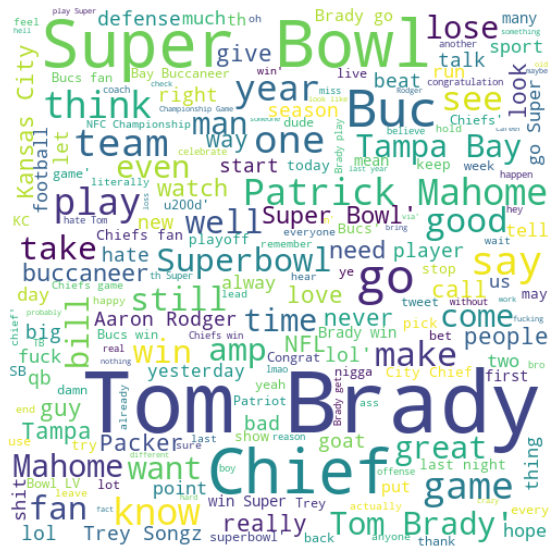

In [88]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(full_clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [89]:
#top polarity values
full_assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
0,Patrick Mahomes / Another legendary performanc...,1.0,1.000000,"[([legendary], 1.0, 1.0, None)]",Patrick Mahomes another legendary performanc...
27104,I woke up today and remembered that the are NF...,1.0,0.666667,"[([super, !, !, !, !, !], 1.0, 0.6666666666666...",wake today remember NFC Champions go play Supe...
4607,Best player comparison for Patrick Lavon Mahom...,1.0,0.300000,"[([best], 1.0, 0.3, None)]",good player comparison Patrick Lavon Mahomes II
18448,Chiefs win! My biography,1.0,0.400000,"[([win, !], 1.0, 0.4, None)]",Chiefs win biography
21619,"Eh, I think you try to match your best CB, Ca...",1.0,0.300000,"[([best], 1.0, 0.3, None)]",eh think try match good CB Carlton Davis Kel...
18449,Onside kick is the best option in the situati...,1.0,0.300000,"[([best], 1.0, 0.3, None)]",onside kick good option situation take field...
4571,Is FalleN the greatest athlete of all time?,1.0,1.000000,"[([greatest], 1.0, 1.0, None)]",FalleN great athlete time
4567,Patrick Lavon Mahomes II is the best quarterb...,1.0,0.300000,"[([best], 1.0, 0.3, None)]",Patrick Lavon Mahomes II good quarterback ev...
17160,I'll 4ever ask.. What is Makaringe's role at ...,1.0,1.000000,"[([perfectly], 1.0, 1.0, None)]",Ill ever ask Makaringes role pirate execute ...
12573,put the po-po in that old school dope fiend!!...,1.0,0.200000,"[([old, !, !, !, !, !, !, !, !, !, !, !, !, !]...",put popo old school dope fiend


In [90]:
top_polar = full_assessments_df.loc[full_assessments_df['Polarity'] >= 0.01]
top_tweets_string = ' '.join(top_polar["UDF Clean Tweets"])
top_tweets_fd = FreqDist(top_tweets_string.split())
top_tweets_fd.most_common(20)

[('…', 5150),
 ('Brady', 3493),
 ('Tom', 2987),
 ('Super', 2436),
 ('Bowl', 2219),
 ('win', 1974),
 ('Chiefs', 1619),
 ('go', 1428),
 ('good', 1295),
 ('get', 1166),
 ('Bucs', 1155),
 ('team', 945),
 ('’', 923),
 ('play', 787),
 ('Mahomes', 758),
 ('year', 750),
 ('great', 747),
 ('fan', 704),
 ('super', 679),
 ('like', 679)]

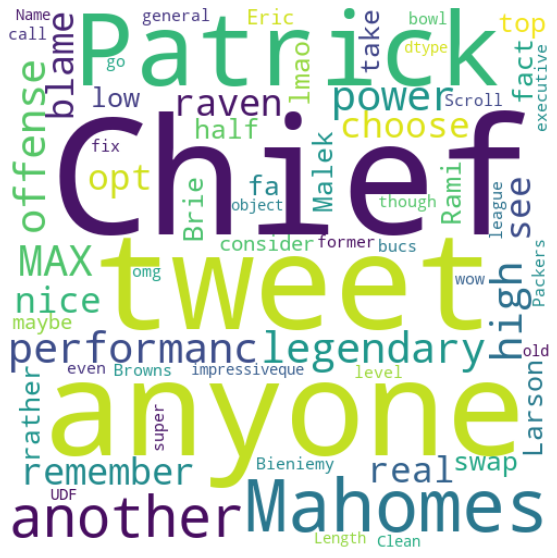

In [91]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [92]:
#lowest polarity values
full_assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
7105,Don’t Ever Question Playoff You IDIOTS!!! Can...,-1.0,0.800000,"[([idiots, !, !, !], -1.0, 0.8, None)]",ever question playoff idiot Can get rip chat
7477,I am appalled by this post by ! It’s he and G...,-1.0,1.000000,"[([appalled, !], -1.0, 1.0, None)]",appal post ’ Gronk give Bucs tea …
16841,the way Chiefs fans analyze games is shocking...,-1.0,1.000000,"[([shocking], -1.0, 1.0, None)]",way Chiefs fan analyze game shocking indeed
2925,Tom Brady looked awful and the Chiefs will bl...,-1.0,1.000000,"[([awful], -1.0, 1.0, None)]",Tom Brady look awful Chiefs blow
26262,Maybe don’t make the worst coaching decision ...,-1.0,1.000000,"[([worst], -1.0, 1.0, None)]",maybe make bad coaching decision playoff tak...
14998,Tom Brady just really disappointed me......be...,-1.0,0.750000,"[([really, disappointed, !, !, !], -1.0, 0.75,...",Tom Brady really disappoint mebeing intervie...
19957,That Bad Mann!!!,-1.0,0.666667,"[([bad, !, !, !], -1.0, 0.6666666666666666, No...",Bad Mann
12623,I get to spend hanging out at the VA while ha...,-1.0,1.000000,"[([horrible], -1.0, 1.0, None)]",get spend hang VA horrible panic attack toda...
6203,Insane fact!,-1.0,1.000000,"[([insane, !], -1.0, 1.0, None)]",insane fact
5142,Vicious,-1.0,1.000000,"[([vicious], -1.0, 1.0, None)]",vicious


In [93]:
low_polar = full_assessments_df.loc[full_assessments_df['Polarity'] <= -0.01]
low_tweets_string = ' '.join(low_polar["UDF Clean Tweets"])
low_tweets_fd = FreqDist(low_tweets_string.split())
low_tweets_fd.most_common(20)

[('…', 2135),
 ('Brady', 1281),
 ('game', 1119),
 ('Tom', 1057),
 ('Chiefs', 719),
 ('go', 543),
 ('get', 514),
 ('hate', 471),
 ('Bucs', 409),
 ('’', 404),
 ('like', 345),
 ('fan', 335),
 ('bad', 295),
 ('say', 294),
 ('fuck', 275),
 ('play', 263),
 ('Trey', 254),
 ('"', 253),
 ('team', 249),
 ('chief', 245)]

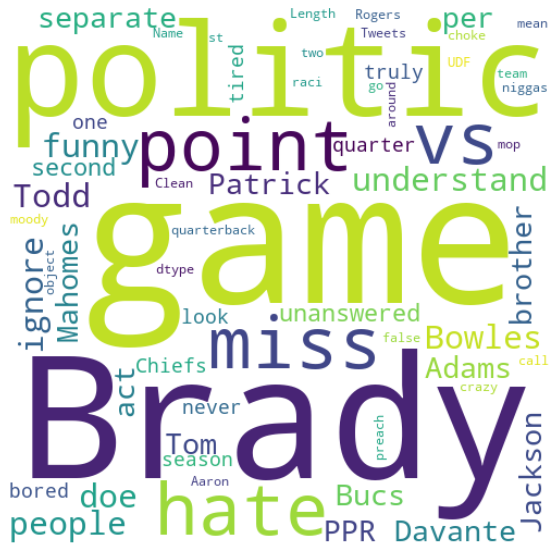

In [94]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

### B. Game-Like Word Clouds

In [95]:
game_tweets_string = ' '.join(clean_tweets)
game_tweets_fd = FreqDist(game_tweets_string.split())
game_tweets_fd.most_common(20)

[('…', 6976),
 ('Brady', 6821),
 ('Tom', 5588),
 ('Chiefs', 3449),
 ('Bucs', 2321),
 ('Super', 2174),
 ('win', 2143),
 ('Bowl', 1986),
 ('go', 1970),
 ('get', 1576),
 ('play', 1418),
 ('game', 1390),
 ('Mahomes', 1377),
 ('’', 1156),
 ('team', 1142),
 ('fan', 1105),
 ('like', 981),
 ('year', 933),
 ('Patrick', 864),
 ('good', 846)]

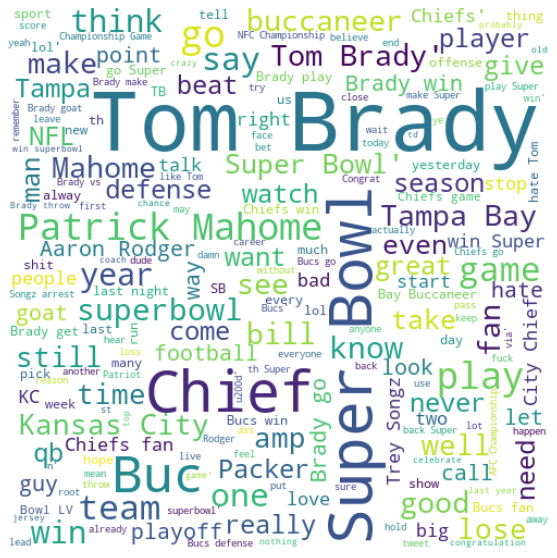

In [96]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [97]:
#top polarity values
assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Keywords,Polarity,Subjectivity,Assessments,UDF Clean Tweets
0,Patrick Mahomes / Another legendary performanc...,"[home, Patrick Mahomes, Mahomes]",1.0,1.00,"[([legendary], 1.0, 1.0, None)]",Patrick Mahomes another legendary performanc...
4640,Tom Brady in 9 SBs\n256-396 (64%) 18 TDs 6 INT...,"[play, Tom Brady, Brady]",1.0,0.30,"[([best], 1.0, 0.3, None)]",Tom Brady sb \n td int yard YPG S...
4696,Those Balls Are Perfect - Tom Brady Songified ...,"[Tom Brady, Brady]",1.0,1.00,"[([perfect], 1.0, 1.0, None)]",ball perfect Tom Brady Songified YouTube
9550,Brady is one of the best QBs of all time and ...,"[goat, Brady]",1.0,0.30,"[([best], 1.0, 0.3, None)]",Brady one good qb time goat …
1941,Awesome! Is that Tom Brady's kid?,"[Tom Brady, Brady]",1.0,1.00,"[([awesome, !], 1.0, 1.0, None)]",Awesome Tom Bradys kid
9570,I’m the biggest Bucs fan I know I can say Bra...,"[play, Bucs, Brady]",1.0,1.00,"[([impressive], 1.0, 1.0, None)]",big Bucs fan know say Brady look impressive ...
9574,Patrick Mahomes the best quarterback I’ve see...,"[home, Patrick Mahomes, Mahomes]",1.0,0.30,"[([best], 1.0, 0.3, None)]",Patrick Mahomes good quarterback see life
4662,Great story on Tom Brady and his sisters. Who ...,"[Tom Brady, Brady]",1.0,0.75,"[([great, !, !], 1.0, 0.75, None)]",great story Tom Brady sister know
9589,Get at for his slander on Tom Brady the Great...,"[Tom Brady, Brady]",1.0,1.00,"[([greatest], 1.0, 1.0, None)]",get slander Tom Brady great time
1964,I'm rooting for the Chiefs too. Best in the A...,"[root, Chiefs]",1.0,0.30,"[([best], 1.0, 0.3, None)]",root Chiefs best AFC West Broncos get work


In [98]:
game_top_polar = assessments_df.loc[assessments_df['Polarity'] >= 0.01]
game_top_tweets_string = ' '.join(game_top_polar["UDF Clean Tweets"])
game_top_tweets_fd = FreqDist(game_top_tweets_string.split())
game_top_tweets_fd.most_common(20)

[('…', 3719),
 ('Brady', 3493),
 ('Tom', 2913),
 ('Super', 2026),
 ('win', 1883),
 ('Bowl', 1843),
 ('Chiefs', 1617),
 ('Bucs', 1155),
 ('go', 1036),
 ('get', 805),
 ('good', 804),
 ('play', 782),
 ('Mahomes', 758),
 ('team', 719),
 ('’', 626),
 ('year', 535),
 ('fan', 508),
 ('Patrick', 502),
 ('game', 486),
 ('like', 486)]

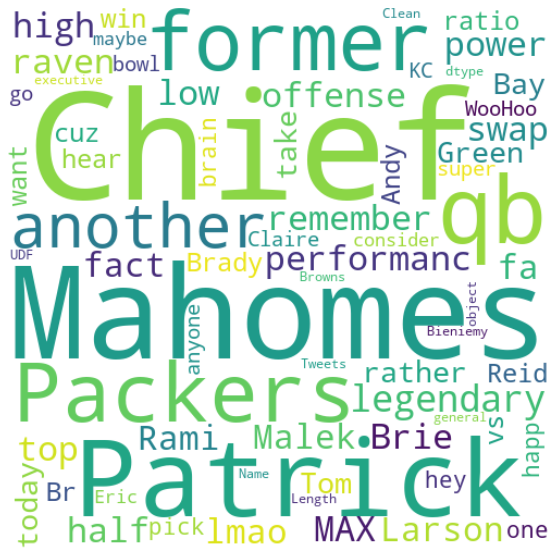

In [99]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(game_top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [100]:
#lowest polarity values
assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Keywords,Polarity,Subjectivity,Assessments,UDF Clean Tweets
3983,Tom Brady is HORRIBLE person.,"[Tom Brady, Brady]",-1.0,1.00,"[([horrible], -1.0, 1.0, None)]",Tom Brady horrible person
15202,Tom Brady isnt horrible because he's a Republ...,"[Tom Brady, Brady]",-1.0,1.00,"[([horrible], -1.0, 1.0, None), ([horrible], -...",Tom Brady horrible Republican horrible Trump...
14917,Holy goat this is absolutely insane,[goat],-1.0,1.00,"[([absolutely, insane], -1.0, 1.0, None)]",Holy goat absolutely insane
14402,LOOOOOL “congratulations Tom Brady... but I’m...,"[Tom Brady, Brady]",-1.0,1.00,"[([disgusted], -1.0, 1.0, None)]","LOOOOOL "" congratulation Tom Brady disgust ""..."
1480,What are you going to do when Covid goes away...,[away],-1.0,1.00,"[([miserable], -1.0, 1.0, None)]",go Covid go away miserable day
16215,The overtime rules are still the worst part of...,[ball],-1.0,1.00,"[([worst], -1.0, 1.0, None)]",overtime rule still bad part football
8121,Not ME! I hate everything about Tom Brady!!!,"[Tom Brady, Brady]",-1.0,0.90,"[([hate, !, !, !], -1.0, 0.9, None)]",hate everything Tom Brady
15312,Maybe don’t make the worst coaching decision ...,"[ball, play, Brady]",-1.0,1.00,"[([worst], -1.0, 1.0, None)]",maybe make bad coaching decision playoff tak...
6287,Brady has never had a terrible team so by all...,"[Tom Brady, Brady]",-1.0,1.00,"[([terrible], -1.0, 1.0, None)]",Brady never terrible team Brady rider logic ...
17469,"Horrible news! Get well soon Fish, Chiefs Kin...",[Chiefs],-1.0,1.00,"[([horrible, !, !], -1.0, 1.0, None)]",horrible news get well soon Fish Chiefs King...


In [101]:
game_low_polar = assessments_df.loc[assessments_df['Polarity'] <= -0.01]
game_low_tweets_string = ' '.join(game_low_polar["UDF Clean Tweets"])
game_low_tweets_fd = FreqDist(game_low_tweets_string.split())
game_low_tweets_fd.most_common(20)

[('…', 1467),
 ('Brady', 1281),
 ('Tom', 1022),
 ('game', 822),
 ('Chiefs', 719),
 ('Bucs', 409),
 ('go', 369),
 ('get', 350),
 ('hate', 336),
 ('play', 258),
 ('fan', 247),
 ('’', 240),
 ('like', 216),
 ('Mahomes', 207),
 ('Trey', 183),
 ('bad', 183),
 ('say', 180),
 ('Songz', 175),
 ('team', 170),
 ('year', 166)]

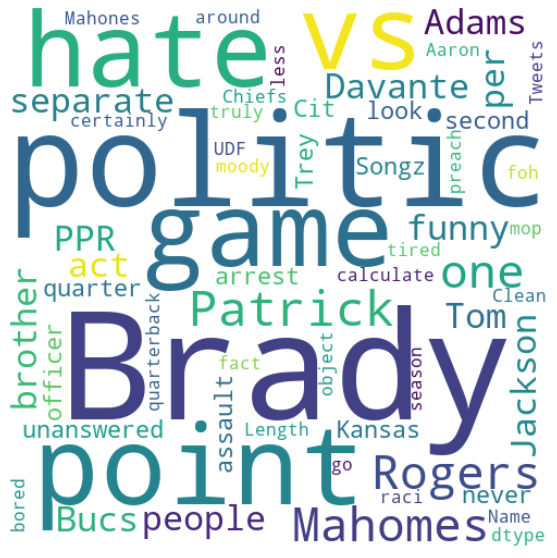

In [102]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(game_low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

### C. Team Word Clouds

#### Kansas City Chiefs

In [103]:
chiefs_tweets_string = ' '.join(chiefs_clean_tweets)
chiefs_tweets_fd = FreqDist(chiefs_tweets_string.split())
chiefs_tweets_fd.most_common(20)

[('Chiefs', 3448),
 ('…', 1905),
 ('Mahomes', 1377),
 ('Patrick', 801),
 ('Super', 773),
 ('Bowl', 739),
 ('Brady', 738),
 ('go', 562),
 ('game', 488),
 ('win', 488),
 ('Tom', 474),
 ('get', 409),
 ('fan', 395),
 ('Kansas', 387),
 ('City', 374),
 ('Bucs', 368),
 ('KC', 313),
 ('vs', 303),
 ('play', 277),
 ('team', 274)]

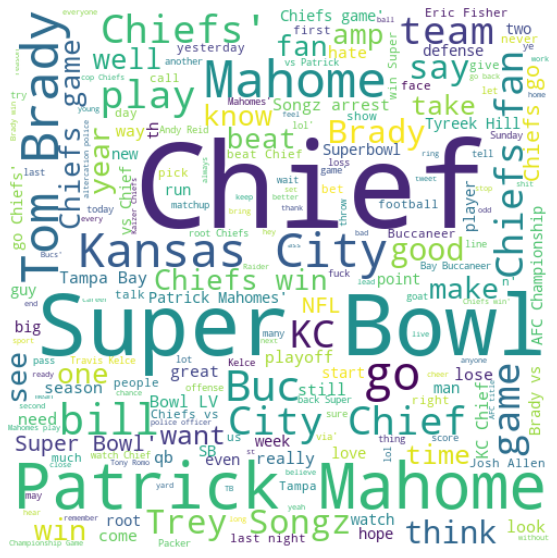

In [104]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(chiefs_clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [105]:
#top polarity values
chiefs_assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
0,Patrick Mahomes / Another legendary performanc...,1.0,1.000000,"[([legendary], 1.0, 1.0, None)]",Patrick Mahomes another legendary performanc...
251,Travis Kelce: Patrick Mahomes was flawless ag...,1.0,1.000000,"[([flawless], 1.0, 1.0, None)]",Travis Kelce Patrick Mahomes flawless bill
2757,Patrick Mahomes the best quarterback I’ve seen...,1.0,0.300000,"[([best], 1.0, 0.3, None)]",Patrick Mahomes good quarterback see life
2763,Another AFCCG loss to the Chiefs at best.,1.0,0.300000,"[([best], 1.0, 0.3, None)]",another afccg loss Chiefs best
2794,Patrick Mahomes the best quarterback I’ve see...,1.0,0.300000,"[([best], 1.0, 0.3, None)]",Patrick Mahomes good quarterback see life
2833,The Chiefs won the AFC the moment you called ...,1.0,0.300000,"[([best], 1.0, 0.3, None)]",Chiefs win AFC moment call Bills good team NFL
2846,"as a chiefs fan, I’m glad we have audio now o...",1.0,1.000000,"[([glad, !, !, !, !], 1.0, 1.0, None)]",chiefs fan glad audio Sway root Chiefs Mahom...
2855,"People are saying Tom Brady is ""the greatest q...",1.0,1.000000,"[([greatest], 1.0, 1.0, None)]",People say Tom Brady great quarterback time li...
2865,The best players and teams step up against com...,1.0,0.300000,"[([best], 1.0, 0.3, None)]",good player team step competition playoff team...
321,Why is the Chiefs defense suddenly incredible...,1.0,0.600000,"[([suddenly, incredible, !], 1.0, 0.9, None), ...",Chiefs defense suddenly incredible Steve Spa...


In [106]:
chiefs_top_polar = chiefs_assessments_df.loc[chiefs_assessments_df['Polarity'] >= 0.01]
chiefs_top_tweets_string = ' '.join(chiefs_top_polar["UDF Clean Tweets"])
chiefs_top_tweets_fd = FreqDist(chiefs_top_tweets_string.split())
chiefs_top_tweets_fd.most_common(20)

[('Chiefs', 1616),
 ('…', 1036),
 ('Mahomes', 758),
 ('Super', 732),
 ('Bowl', 695),
 ('Patrick', 471),
 ('Brady', 456),
 ('win', 440),
 ('Tom', 312),
 ('go', 295),
 ('good', 239),
 ('get', 202),
 ('Kansas', 186),
 ('City', 183),
 ('Bucs', 180),
 ('vs', 178),
 ('fan', 173),
 ('team', 166),
 ('KC', 150),
 ('’', 146)]

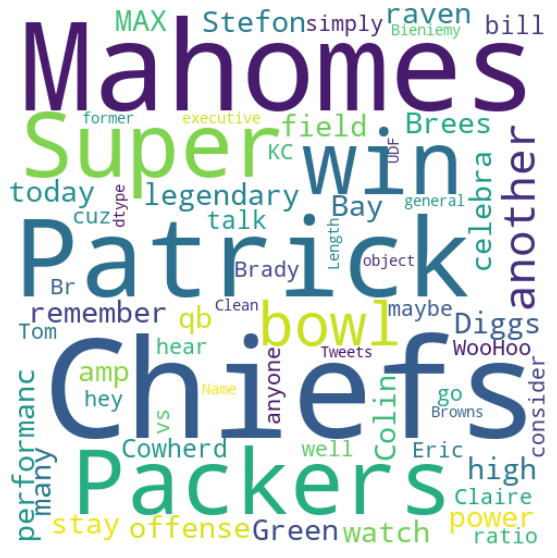

In [107]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(chiefs_top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [108]:
#lowest polarity values
chiefs_assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
3125,The amount of bandwagon Chiefs fans is insane ...,-1.0,1.0,"[([insane], -1.0, 1.0, None)]",amount bandwagon Chiefs fan insane melet ’s Ri...
2579,No way. Brady is the worst. I hope the Chiefs...,-1.0,1.0,"[([worst], -1.0, 1.0, None)]",way Brady bad hope Chiefs sack time throw ...
135,Tyreek Hill’s yards-after-the-catch ability is...,-1.0,1.0,"[([insane], -1.0, 1.0, None)]",Tyreek Hill ’s yardsafterthecatch ability insa...
1193,The Kansas City Chiefs are boring to watch. Th...,-1.0,1.0,"[([boring], -1.0, 1.0, None)]",Kansas City Chiefs bore watch say
4935,Tyreke Hill is insane. Im picking Chiefs to be...,-1.0,1.0,"[([insane], -1.0, 1.0, None)]",Tyreke Hill insane pick Chiefs beat TB home
3371,Chiefs haven't lost since Oct. That's insane.,-1.0,1.0,"[([insane], -1.0, 1.0, None)]",Chiefs lose since Oct insane
2851,the way Chiefs fans analyze games is shocking...,-1.0,1.0,"[([shocking], -1.0, 1.0, None)]",way Chiefs fan analyze game shocking indeed
1486,Truly the worst superbowl for Broncos fans... ...,-1.0,1.0,"[([worst], -1.0, 1.0, None)]",truly bad superbowl Broncos fan KC Tom terrifi...
3244,"My heart says Mahomes, but my ""football sense""...",-1.0,0.9,"[([hate, !], -1.0, 0.9, None)]",heart say Mahomes football sense say Brady hat...
5088,"Horrible news! Get well soon Fish, Chiefs Kin...",-1.0,1.0,"[([horrible, !, !], -1.0, 1.0, None)]",horrible news get well soon Fish Chiefs King...


In [109]:
chiefs_low_polar = chiefs_assessments_df.loc[chiefs_assessments_df['Polarity'] <= -0.01]
chiefs_low_tweets_string = ' '.join(chiefs_low_polar["UDF Clean Tweets"])
chiefs_low_tweets_fd = FreqDist(chiefs_low_tweets_string.split())
chiefs_low_tweets_fd.most_common(20)

[('Chiefs', 719),
 ('…', 397),
 ('game', 327),
 ('Mahomes', 207),
 ('Trey', 166),
 ('Songz', 166),
 ('arrest', 123),
 ('Patrick', 103),
 ('go', 102),
 ('Game', 94),
 ('Kansas', 93),
 ('get', 93),
 ('fan', 91),
 ('City', 90),
 ('Brady', 87),
 ('KC', 73),
 ('cop', 67),
 ('hate', 61),
 ('like', 60),
 ('altercation', 58)]

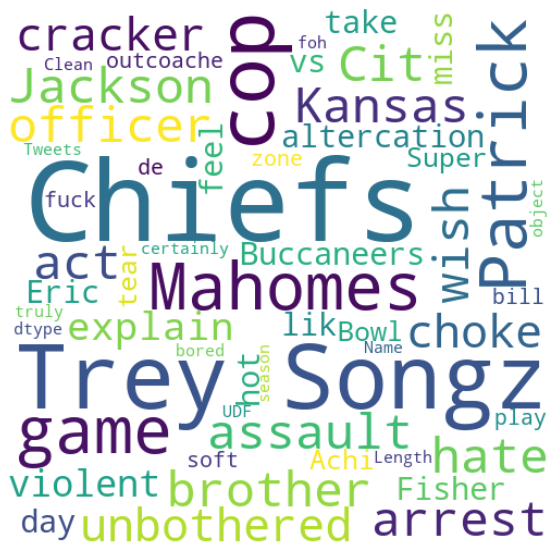

In [110]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(chiefs_low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#### Tampa Bay Buccaneers

In [111]:
bucs_tweets_string = ' '.join(bucs_clean_tweets)
bucs_tweets_fd = FreqDist(bucs_tweets_string.split())
bucs_tweets_fd.most_common(20)

[('Brady', 6821),
 ('Tom', 5490),
 ('…', 3459),
 ('Bucs', 2320),
 ('Super', 1566),
 ('Bowl', 1429),
 ('win', 1050),
 ('go', 1021),
 ('get', 808),
 ('Chiefs', 652),
 ('’', 652),
 ('play', 629),
 ('game', 595),
 ('fan', 583),
 ('Tampa', 564),
 ('team', 561),
 ('like', 556),
 ('Mahomes', 516),
 ('year', 480),
 ('buccaneer', 457)]

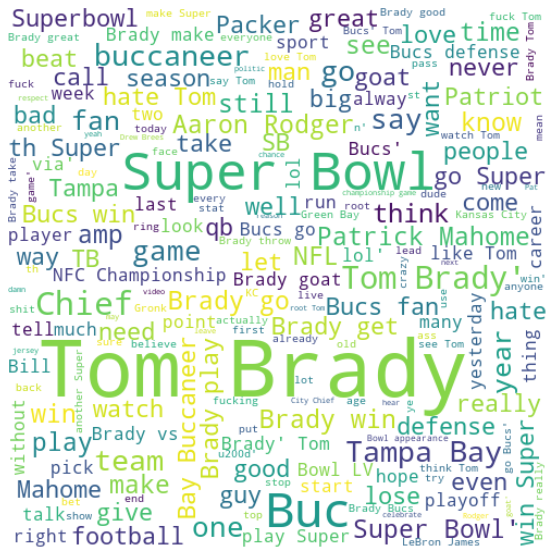

In [112]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(bucs_clean_tweets))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

#Note, sometimes the cell needs to be run twice for the image to populate

#### Word Counts for Polarity

In [113]:
#top polarity values
bucs_assessments_df.sort_values(by = 'Polarity', ascending=False).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
6502,And my Buccaneers 12-1 to win lives!,1.0,0.4,"[([win, !], 1.0, 0.4, None)]",buccaneer win life
3347,Tom Brady is the greatest WINNER we’ve ever s...,1.0,1.0,"[([greatest], 1.0, 1.0, None)]","Tom Brady great winner ever see "" athlete "" ..."
6123,Take of the day: Tom Brady is the greatest ath...,1.0,1.0,"[([greatest], 1.0, 1.0, None)]",take day Tom Brady great athlete time talk ath...
6723,Best of luck to the Chiefs! Crush Brady!,1.0,0.3,"[([best, !, !], 1.0, 0.3, None)]",good luck Chiefs Crush Brady
6405,Is Tom Brady the greatest qb of all time? No. ...,1.0,1.0,"[([greatest], 1.0, 1.0, None), ([greatest], 1....",Tom Brady great qb time Tom Brady great qb tim...
2072,The homie been on Facebook since 6am ranting a...,1.0,1.0,"[([greatest], 1.0, 1.0, None)]",homie Facebook since rant Tom Brady great athl...
3288,Congratulations to Tom Brady &amp; the Buccane...,1.0,0.3,"[([best], 1.0, 0.3, None)]",congratulation Tom Brady amp buccaneer NE wish...
8210,The best players in the country play COLLEGE F...,1.0,0.3,"[([best], 1.0, 0.3, None)]",good player country play college football matt...
706,have u maybe considered that Tom Brady ISNT th...,1.0,1.0,"[([greatest], 1.0, 1.0, None)]",u maybe consider Tom Brady ISNT great quarterb...
7501,Tom Brady is the best football player and bes...,1.0,0.3,"[([best], 1.0, 0.3, None), ([best], 1.0, 0.3, ...",Tom Brady good football player good winner e...


In [114]:
bucs_top_polar = bucs_assessments_df.loc[bucs_assessments_df['Polarity'] >= 0.01]
bucs_top_tweets_string = ' '.join(bucs_top_polar["UDF Clean Tweets"])
bucs_top_tweets_fd = FreqDist(bucs_top_tweets_string.split())
bucs_top_tweets_fd.most_common(20)

[('Brady', 3493),
 ('Tom', 2856),
 ('…', 1907),
 ('Super', 1456),
 ('Bowl', 1324),
 ('Bucs', 1154),
 ('win', 898),
 ('go', 547),
 ('get', 417),
 ('good', 403),
 ('play', 400),
 ('team', 373),
 ('Chiefs', 370),
 ('’', 362),
 ('Tampa', 357),
 ('Mahomes', 326),
 ('great', 301),
 ('super', 299),
 ('year', 298),
 ('like', 292)]

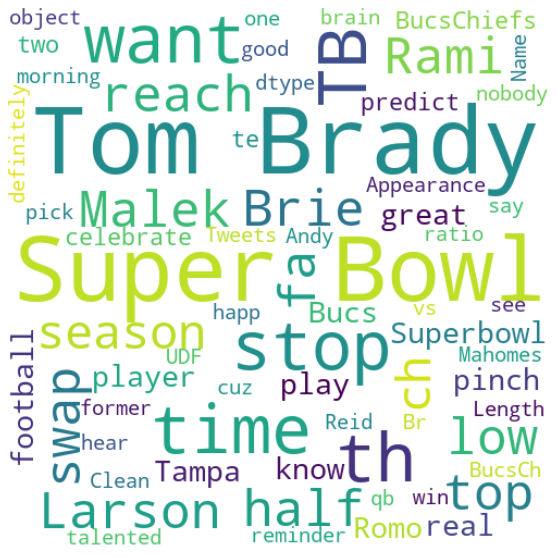

In [115]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(bucs_top_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [116]:
#lowest polarity values
bucs_assessments_df.sort_values(by = 'Polarity', ascending=True).iloc[:20]

,Tweet,Polarity,Subjectivity,Assessments,UDF Clean Tweets
4011,"... Let me get this str8, there’s Tom Brady fa...",-1.0,1.0,"[([insane, !, !, !], -1.0, 1.0, None)]","let get str ’ Tom Brady fan longer fan \n "" ..."
749,As a Bucs fan.. terrifying,-1.0,1.0,"[([terrifying], -1.0, 1.0, None)]",Bucs fan terrify
6008,"My heart says Mahomes, but my ""football sense""...",-1.0,0.9,"[([hate, !], -1.0, 0.9, None)]",heart say Mahomes football sense say Brady hat...
2889,I hate to say I told you so BUT I TOLD YOU SO!...,-1.0,0.9,"[([hate, !, !, !], -1.0, 0.9, None)]",hate say tell tell tell Tom Brady would beat A...
8142,Tom Brady isnt horrible because he's a Republ...,-1.0,1.0,"[([horrible], -1.0, 1.0, None), ([horrible], -...",Tom Brady horrible Republican horrible Trump...
7352,Let’s just say that if you put Tom Brady on t...,-1.0,1.0,"[([worst], -1.0, 1.0, None)]",let ’s say put Tom Brady bad team NFL would ...
3383,Brady has never had a terrible team so by all...,-1.0,1.0,"[([terrible], -1.0, 1.0, None)]",Brady never terrible team Brady rider logic ...
4347,Not ME! I hate everything about Tom Brady!!!,-1.0,0.9,"[([hate, !, !, !], -1.0, 0.9, None)]",hate everything Tom Brady
2256,Tom Brady was the worst QB playing yesterday,-1.0,1.0,"[([worst], -1.0, 1.0, None)]",Tom Brady bad qb play yesterday
2148,Tom Brady is HORRIBLE person.,-1.0,1.0,"[([horrible], -1.0, 1.0, None)]",Tom Brady horrible person


In [117]:
bucs_low_polar = bucs_assessments_df.loc[bucs_assessments_df['Polarity'] <= -0.01]
bucs_low_tweets_string = ' '.join(bucs_low_polar["UDF Clean Tweets"])
bucs_low_tweets_fd = FreqDist(bucs_low_tweets_string.split())
bucs_low_tweets_fd.most_common(20)

[('Brady', 1281),
 ('Tom', 1012),
 ('…', 675),
 ('Bucs', 409),
 ('game', 326),
 ('hate', 244),
 ('go', 178),
 ('get', 167),
 ('fan', 129),
 ('’', 126),
 ('bad', 113),
 ('like', 111),
 ('say', 102),
 ('play', 98),
 ('win', 93),
 ('fuck', 92),
 ('Super', 91),
 ('Chiefs', 89),
 ('make', 87),
 ('Bowl', 83)]

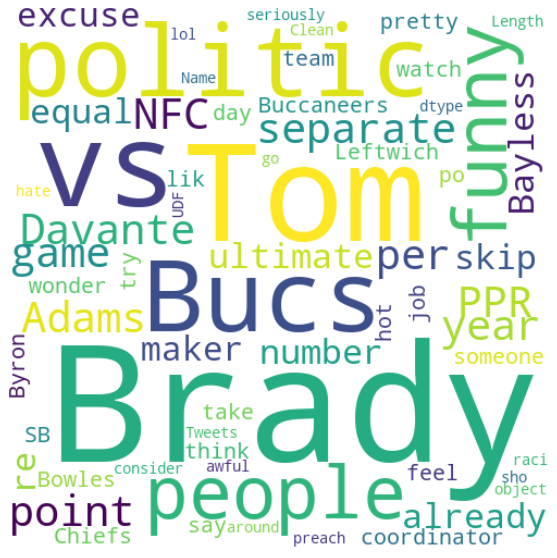

In [118]:
fig = plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=500, height=500, background_color ="white").generate(str(bucs_low_polar["UDF Clean Tweets"]))


plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

## 12. DBSCAN Clustering

### A. Full Tweets

In [119]:
vectorizer = TfidfVectorizer(min_df=10) #min number of tweets (min doc freq)
features = vectorizer.fit_transform(full_clean_tweets) #full dataset
type(features)

scipy.sparse.csr.csr_matrix

In [120]:
features.shape

(30171, 2227)

In [121]:
#convert matrix to numpy dense matrix
features = features.todense()

In [122]:
# make a model
model = DBSCAN(eps=0.5, min_samples=40, n_jobs= -1) 


In [123]:
model.fit(features)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=40, n_jobs=-1, p=None)

In [124]:
labels = model.labels_ #get model labels

In [125]:
no_clusters = len(np.unique(labels)) #number of unique labels
no_noise = np.sum(np.array(labels) == -1, axis=0) # number of outliers OR model.labels_[model.labels_ == -1].size 


print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)



Estimated no. of clusters: 9
Estimated no. of noise points: 29262


In [126]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(features, labels))

Silhouette Coefficient: -0.253


In [127]:
cluster0_tweets = np.array(full_clean_tweets)[labels == 0] #get tweets in cluster = 0
len(cluster0_tweets)

524

In [128]:
cluster0_tweets

array([' ', ' ', '  redemption', 'OSU', 'terrifying', '', ' ',
       '  Tyrone  ', ' ', '  ahem', 'Wowza', '  hello',
       '  meeee thoughhh', 'outscooped', '', '', ' ', 'wowzers',
       'nonchalant', 'trolling definition', 'mindboggling', '', 'salt',
       '  waitin', '  ahem', 'M Waltrip', 'murder', '  sour grape',
       'woot', '', ' ', '', 'Monare', '', 'shabby', 'factoid', ' ',
       'platform', 'information factual', '  Mindboggling',
       '  bitter bitter bitter', 'showman', '', 'Favre',
       '  Fukkk   fascist bastard', '  whoops', '  SCOOOOOTER',
       'goodness', 'reeks whew chileeee ghetto 🤦 \u200d', '', 'Wassup',
       ' ', 'Joseph Rasheed', 'LMFAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO',
       'Dawgg', '  Joseph Rasheed', '  Excellence', 'yike panoramic',
       'surgeon gtgtgtgtgtgt', 'boyssss', '', '   ward dumaine', 'ouch',
       'HeineKEE ballin', '', 'dicky V ‼', 'LMFAOOOOOOO', ' ',
       '  HeineKEE ballin', '', 'LMFAOOOOO', '', 'goodness 🤯', 'bruhhh',
       

In [129]:
wordcount0 = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_tweets)))
print('Cluster 1 contains',len(wordcount0),'words.')

Cluster 1 contains 503 words.


In [130]:
wordcount0.most_common(15)

[('…', 20),
 ('’', 19),
 ('``', 10),
 ('🤣', 8),
 ('\u200d', 6),
 ('Rasheed', 4),
 ('ouch', 4),
 ('🤩', 4),
 ('ding', 4),
 ('bitter', 3),
 ('whew', 3),
 ('u', 3),
 ('🤔', 3),
 ('arghhhhhh', 3),
 ('boop', 3)]

In [131]:
cluster_tweets = [] #tokenize words in each cluster and compute the counts for each token 

for i in range(0, no_clusters):
    cluster_tweets.append(nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(np.array(full_clean_tweets)[labels == i]))))

In [132]:
for i in range(0, len(cluster_tweets)):
    print('Cluster', i+1,'-', cluster_tweets[i].most_common(10), '\n') #most common words in each cluster
    

Cluster 1 - [('…', 20), ('’', 19), ('``', 10), ('🤣', 8), ('\u200d', 6), ('Rasheed', 4), ('ouch', 4), ('🤩', 4), ('ding', 4), ('bitter', 3)] 

Cluster 2 - [('fuck', 34), ('Fuck', 23), ('Brady', 19), ('Tom', 18), ('FUCK', 14), ('TOM', 13), ('BRADY', 13), ('brady', 9), ('tom', 8), ('🤣', 7)] 

Cluster 3 - [('Brady', 96), ('Tom', 91), ('tom', 26), ('brady', 26), ('TOM', 8), ('BRADY', 8), ('’', 8), ('…', 3), ('antichrist', 2), ('affect', 2)] 

Cluster 4 - [('chief', 40), ('Famba', 1), ('Manda', 1), ('hello', 1), ('waitgo', 1), ('Goooooo', 1), ('tudder', 1), ('entirety', 1), ('monie', 1), ('gush', 1)] 

Cluster 5 - [('Chiefs', 60), ('``', 4), ('W', 2), ('Gooooooo', 1), ('Dolphins', 1), ('🤝', 1), ('Cyclone', 1), ('Cyril', 1), ('Cele', 1), ('Corona', 1)] 

Cluster 6 - [('goat', 34), ('Brady', 15), ('Tom', 14), ('GOAT', 7), ('``', 4), ('brady', 3), ('’', 3), ('foreal', 2), ('tom', 2), ('aight', 2)] 

Cluster 7 - [('go', 45), ('Bucs', 13), ('bucs', 7), ("'", 2), ('🤣', 2), ('nvm', 1), ('commando', 

### B. Game Tweets

In [133]:
vectorizer = TfidfVectorizer(min_df=10) #min number of tweets (min doc freq)
features = vectorizer.fit_transform(clean_tweets) #game dataset
type(features)

scipy.sparse.csr.csr_matrix

In [134]:
features.shape

(17600, 1591)

In [135]:
#convert matrix to numpy dense matrix
features = features.todense()

In [136]:
# make a model
model = DBSCAN(eps=0.5, min_samples=40, n_jobs= -1) 

In [137]:
model.fit(features)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=40, n_jobs=-1, p=None)

In [138]:
labels = model.labels_

In [139]:
no_clusters = len(np.unique(labels)) #number of unique labels
no_noise = np.sum(np.array(labels) == -1, axis=0) # number of outliers OR model.labels_[model.labels_ == -1].size 


print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)



Estimated no. of clusters: 3
Estimated no. of noise points: 17428


In [140]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(features, labels))

Silhouette Coefficient: -0.041


In [141]:
cluster0_tweets = np.array(clean_tweets)[labels == 0] #get tweets in cluster = 0
len(cluster0_tweets)

109

In [142]:
cluster0_tweets

array(['Tom Brady Conor McGregor 🤷 \u200d', '  Tom Brady', 'Tom Brady',
       '  Tom Brady', '  frame Tom Brady', '  Fk Tom Brady',
       'Thisgreedy Brady', '  Tom Brady', '  Tom Brady antichrist',
       'Tom Brady', 'Gross Tom Brady', 'Tom Brady', '  awe Tom Brady',
       '  Tom Brady', 'Tom Brady', '  ’ Tom Brady', 'Tom Brady',
       '  Tom Brady affect', '  Tom Brady antichrist', '  Tom Brady sus',
       '  goddamn Tom Brady', 'Tom Brady status 🤩', '  Brady beast',
       '  Tom BradyGOATIf', 'Tom Brady', 'Tom Brady', 'Brady voodoo',
       '  Tom Brady', '  Tom Brady', '  Tom Brady  ',
       'Tom GetitinBlood Brady', '  Tom Brady Johnny Bananas',
       '  leak Tom Brady text', '  Tom Brady', '  Tom Brady',
       'Tom Brady  ', '  tom Brady', '  Tom Brady', '  Tom Brady pos',
       'Tom Brady', 'Tom Brady Johnny Bananas', '  Petty Tom Brady',
       '  Tom Brady', '  Tom Brady', 'loathe Tom Brady',
       'Tom Brady music', '  Tom Brady GOATed', 'Tom Brady \n\n',
       '

In [143]:
wordcount0 = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_tweets)))
print('Cluster 1 contains',len(wordcount0),'words.')

Cluster 1 contains 94 words.


In [144]:
wordcount0.most_common(15)

[('Brady', 108),
 ('Tom', 97),
 ('’', 7),
 ('…', 3),
 ('antichrist', 2),
 ('affect', 2),
 ('Johnny', 2),
 ('Bananas', 2),
 ('tom', 2),
 ('jerk', 2),
 ('Chili', 2),
 ('Edin', 2),
 ('F', 2),
 ('Conor', 1),
 ('McGregor', 1)]

In [145]:
cluster_tweets = [] #tokenize words in each cluster and compute the counts for each token 

for i in range(0, no_clusters):
    cluster_tweets.append(nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(np.array(clean_tweets)[labels == i]))))

In [146]:
for i in range(0, len(cluster_tweets)):
    print('Cluster', i+1,'-', cluster_tweets[i].most_common(10), '\n') #most common words in each cluster
    

Cluster 1 - [('Brady', 108), ('Tom', 97), ('’', 7), ('…', 3), ('antichrist', 2), ('affect', 2), ('Johnny', 2), ('Bananas', 2), ('tom', 2), ('jerk', 2)] 

Cluster 2 - [('Chiefs', 64), ('``', 4), ('W', 2), ('Gooooooo', 1), ('Dolphins', 1), ('🤝', 1), ('Cyclone', 1), ('Cyril', 1), ('Cele', 1), ('Corona', 1)] 

Cluster 3 - [] 



In [147]:
#could use function similar to the one below to try and find "ideal" eps and minpts values

# eps = [0.2, 0.5, 0.75, 1.00]
# minpts = [20, 25, 30, 40]

# for x in eps:
#     for y in minpts:
#         model = DBSCAN(eps=x, min_samples=y, n_jobs= -1)
#         model.fit(features)
#         labels = model.labels_
#         no_clusters = len(np.unique(labels)) #number of unique labels
#         no_noise = np.sum(np.array(labels) == -1, axis=0)
#         print('Epsilon (eps): %0.1f' % x)
#         print('Minimum samples (minPts): %d' % y)
#         print('Estimated no. of clusters: %d' % no_clusters)
#         print('Estimated no. of noise points: %d' % no_noise)
#         print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(features, labels))
#         print('\n')

In [148]:
#%history

In [149]:
#client.close()

# Resources

1. Import data from MongoDB: https://stackoverflow.com/questions/16249736/how-to-import-data-from-mongodb-to-pandas
2. Remove emoji's: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b 
2. Reindex dataframe: https://stackoverflow.com/questions/28885073/reindexing-after-pandas-drop-duplicates
3. Multidict: https://medium.com/analytics-vidhya/mapping-keys-to-multiple-values-in-a-dictionary-b5022de9dd0e
4. Textblob: https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/
5. spaCy: https://spacy.io/
6. Word cloud: https://www.geeksforgeeks.org/generating-word-cloud-python/
7. DBSCAN model: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan
8. Estimate clusters and noise points: https://www.machinecurve.com/index.php/2020/12/09/performing-dbscan-clustering-with-python-and-scikit-learn/
9. Silhouette score: https://shritam.medium.com/how-dbscan-algorithm-works-2b5bef80fb3
10. TF-IDF: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html